# Pokemon Team Composition Analysis
This notebook aims to provide a complete analysis for team composition, choose your 6 pokemons below and run it trough so you can get an overview of your team

In [46]:
# Setup, just putting together what we will need to do the analysis
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.spines import Spine
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection

%matplotlib inline
pokemon_data = pd.read_csv('../datasets/pokemon-stats.csv')
damage_mul = pd.read_csv('./damage_multipliers.csv')
status = ['HP','Attack','Defense','Sp. Atk','Sp. Def','Speed']
pokemon_data.head()

,#,Name,Type1,Type2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


In [47]:
damage_mul.head()

,Attacking,Normal,Fire,Water,Electric,Grass,Ice,Fighting,Poison,Ground,Flying,Psychic,Bug,Rock,Ghost,Dragon,Dark,Steel,Fairy
0,Normal,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5,0.0,1.0,1.0,0.5,1.0
1,Fire,1,0.5,0.5,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,0.5,1.0,0.5,1.0,2.0,1.0
2,Water,1,2.0,0.5,1.0,0.5,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,1.0,0.5,1.0,1.0,1.0
3,Electric,1,1.0,2.0,0.5,0.5,1.0,1.0,1.0,0.0,2.0,1.0,1.0,1.0,1.0,0.5,1.0,1.0,1.0
4,Grass,1,0.5,2.0,1.0,0.5,1.0,1.0,0.5,2.0,0.5,1.0,0.5,2.0,1.0,0.5,1.0,0.5,1.0


In [48]:
# Setup your team! Choose 6 pokemon in the list below
team = ["Milotic", "Aggron", "Vigoroth", "Raichu", "Breloom", "Alakazam"]

In [49]:
# Let's gather only your team's data
team_data = pokemon_data.query("Name in @team")
team_data

,#,Name,Type1,Type2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
31,26,Raichu,Electric,NaN,485,60,90,55,90,80,110,1,False
70,65,Alakazam,Psychic,NaN,500,55,50,45,135,95,120,1,False
310,286,Breloom,Grass,Fighting,460,60,130,80,60,60,70,3,False
312,288,Vigoroth,Normal,NaN,440,80,80,80,55,55,90,3,False
332,306,Aggron,Steel,Rock,530,70,110,180,60,60,50,3,False
382,350,Milotic,Water,NaN,540,95,60,79,100,125,81,3,False


In [50]:
# First, let's see your types matchups
# Primary types
team_types = team_data["Type1"].unique().tolist()
# Secundary types may be NaN, let's deal with it
team_types.extend(team_data["Type2"].dropna().unique().tolist())
all_types = damage_mul["Attacking"].unique()
attack_matchups = {}
defense_matchups = {}

for p in team:
    t1 = pokemon_data[pokemon_data["Name"] == p]["Type1"].item()
    t2 = False
    if pokemon_data[pokemon_data["Name"] == p]["Type2"].any():
        t2 = pokemon_data[pokemon_data["Name"] == p]["Type2"].item()
    for t in all_types:
        att_mul =damage_mul[damage_mul["Attacking"] == t1][t].item()
        def_mul = damage_mul[damage_mul["Attacking"] == t][t1].item()
        if t2:
            # In case you have a dual type poke, we get the max multiplier for the attack
            # and the product for the defense
            att_mul = max(att_mul,damage_mul[damage_mul["Attacking"] == t2][t].item())
            def_mul *=damage_mul[damage_mul["Attacking"] == t][t2].item()
        attack_matchups[t] = attack_matchups.get(t, 0) + att_mul
        defense_matchups[t] = defense_matchups.get(t,0) + def_mul
        
attack_matchups = pd.DataFrame(attack_matchups, index=['Score']).T.sort_values('Score', ascending=False).T
defense_matchups = pd.DataFrame(defense_matchups, index=['Score']).T.sort_values('Score', ascending=False).T
status_data = pd.melt(team_data, id_vars=['#','Name','Type1', 'Type2','Legendary','Generation', 'Total'], var_name="Stat")

## Types Matchups
The graphs below show your team's score in both attack and defense matchup, this is calculated as the sum of multipliers of your team against each type for both attack and defense, then the defense score is calculated as 24 (the max possible score for a given type) minus the sum

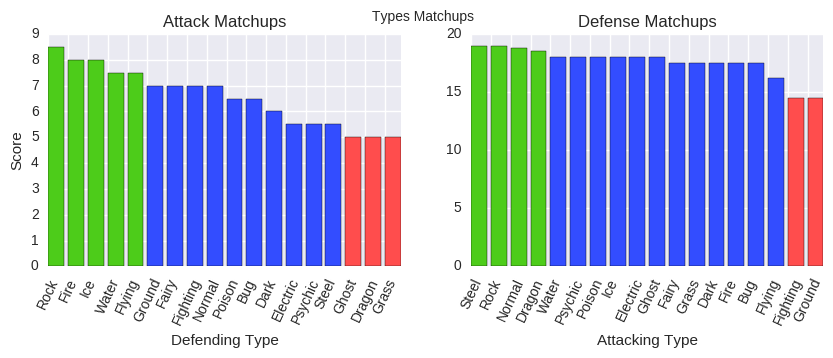

In [51]:
plt.figure(figsize=(10,3))
plt.subplot(121)
plt.suptitle("Types Matchups")
plt.title("Attack Matchups")
plt.xlabel("Defending Type")
plt.ylabel("Score")
plt.xticks(range(18), attack_matchups.columns,rotation=65)

att_color = lambda x:(1,0.3,0.3) if x <= 5 else (0.2,0.3,1) if x <= 7 else (0.3, 0.8, 0.1)
def_color = lambda x:(1,0.3,0.3) if x > 8 else (0.2,0.3,1) if x >= 6 else (0.3, 0.8, 0.1)

for x, v in zip(range(18), attack_matchups.values[0]):
    plt.bar(x,v, color=att_color(v))
plt.subplot(122)
plt.title("Defense Matchups")
plt.xlabel("Attacking Type")
plt.xticks(range(18), defense_matchups.columns[::-1],rotation=65)
for x, v in zip(range(18), defense_matchups.values[0][::-1]):
    plt.bar(x,24-v, color=def_color(v))
    
plt.show()

## Status Analysis
Here you can see an analysis for your team's stats, in the graph below you see how each of your team's pokemons compares to the average status

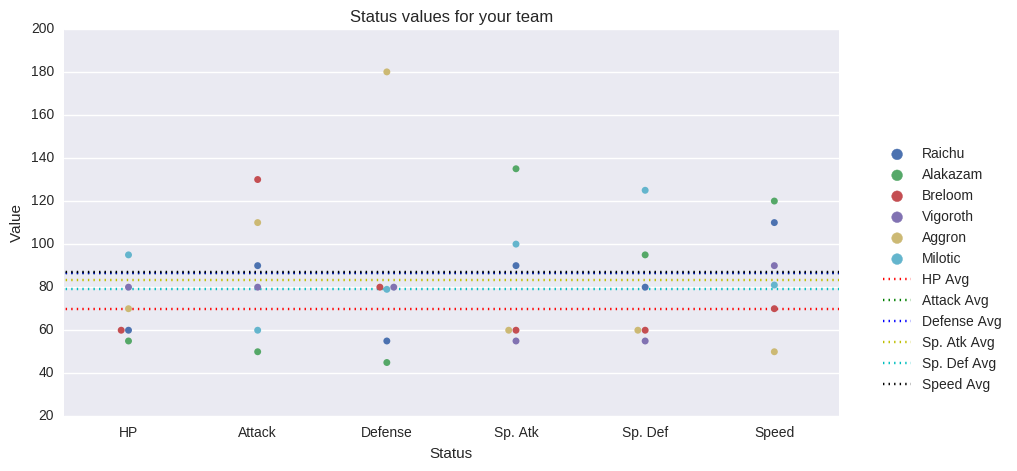

HP         69.25875
Attack     79.00125
Defense    73.84250
Sp. Atk    72.82000
Sp. Def    71.90250
Speed      68.27750
dtype: float64
HP         70.000000
Attack     86.666667
Defense    86.500000
Sp. Atk    83.333333
Sp. Def    79.166667
Speed      86.833333
dtype: float64


In [52]:
plt.figure(figsize=(10,5))
plt.title("Status values for your team")
sns.swarmplot(x="Stat", y="value", data=status_data, hue="Name")
plt.ylabel("Value")
plt.xlabel("Status")
colors = ['r','g','b','y','c','k']
for stat,c in zip(status,colors):
    plt.hlines(team_data[stat].mean(),-1,6, linestyles='dotted', color=c, label="%s Avg"%stat)
plt.legend(loc=(1.05,0.05))
plt.show()
print(pokemon_data[status].mean())
print(team_data[status].mean())

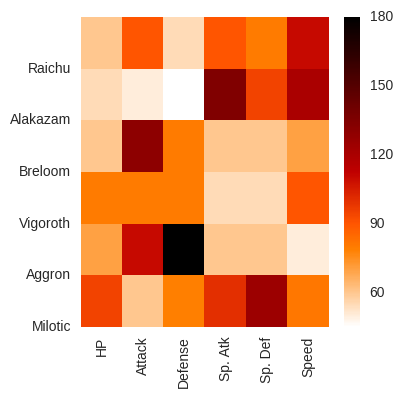

In [53]:
fig = plt.figure( figsize=(4,4))
ax = plt.subplot(111)
sns.heatmap(team_data[status], cmap='gist_heat_r')
plt.yticks(range(6), team_data["Name"][::-1], rotation=0)
plt.xticks(rotation=90)
plt.show()

## Archenemies
Below you can find an analysis that seeks to point out which pokemons you should be aware of when battling, this analysis takes into account the type matchups of your team

In [58]:
# Let's get you 3 worst attack and defense matchups
att_w = attack_matchups.columns[-3:].tolist()
def_w = defense_matchups.columns[-3:].tolist()
archenemy = pokemon_data.query("Type1 in @att_w or Type2 in @att_w")
archenemy.query("Type1 in @def_w or Type2 in @def_w")

,#,Name,Type1,Type2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
377,345,Lileep,Rock,Grass,355,66,41,77,61,87,23,3,False
378,346,Cradily,Rock,Grass,495,86,81,97,81,107,43,3,False
540,483,Dialga,Steel,Dragon,680,100,120,120,150,100,90,4,True
646,585,Deerling,Normal,Grass,335,60,60,50,40,50,75,5,False
647,586,Sawsbuck,Normal,Grass,475,80,100,70,60,70,95,5,False
658,597,Ferroseed,Grass,Steel,305,44,50,91,24,86,10,5,False
659,598,Ferrothorn,Grass,Steel,489,74,94,131,54,116,20,5,False
748,679,Honedge,Steel,Ghost,325,45,80,100,35,37,28,6,False
749,680,Doublade,Steel,Ghost,448,59,110,150,45,49,35,6,False
750,681,AegislashBlade Forme,Steel,Ghost,520,60,150,50,150,50,60,6,False
